# Red Wine Quality Prediction

Problem Statement:


The dataset is related to red and white variants of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

This dataset can be viewed as classification task. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Attribute Information

Input variables (based on physicochemical tests):


1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
Output variable (based on sensory data):
12 - quality (score between 0 and 10)

What might be an interesting thing to do, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'.
This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value.

You need to build a classification model. 

In [6]:
import warnings
warnings.simplefilter("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/DSData/master/winequality-red.csv")

Instead of downloading the entire dataset on my local computer I am simply loading the file directly from the GitHub repository link using the raw option.

In [8]:
df # Taking a look at the dataset's first and last 5 rows showcasing all the column names as well

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


So by taking a look at the above data frame I can see that the column quality is the target label making the remaining columns as the features that we can customize and use to predict our label. This classifies to be a Classification problem!

# Exploratory Data Analysis (EDA)

In [9]:
df.shape

(1599, 12)

In [10]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Luckily we do not see any missing values in any of the columns of our dataset so we don't have to worry about handling missing data.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Great none of the columns have any object data type values and our label is the only integer value making all the feature columns as float datatype i.e. similar datatype.

In [12]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Using the describe method I can see the count, mean, standard deviation, minimum, maximum and inter quantile values of our dataset.

As per my observation:

1.There is a big gap between 75% and max values of residual sugar column

2.There is a big gap between 75% and max values of free sulfur dioxide column

3.There is a huge gap between 75% and max value of total sulfur dioxide column


All these gaps indicate that there are outliers present in our dataset which might need to be treated so as to get a better model accuracy later.

In [13]:
df.skew() # acceptable range is +/-0.5

fixed acidity           0.982751
volatile acidity        0.671593
citric acid             0.318337
residual sugar          4.540655
chlorides               5.680347
free sulfur dioxide     1.250567
total sulfur dioxide    1.515531
density                 0.071288
pH                      0.193683
sulphates               2.428672
alcohol                 0.860829
quality                 0.217802
dtype: float64

Here we see the skewness information present in our dataset. We will ignore quality since it is our target label in the dataset. Now taking a look at all the feature columns we see that fixed acidity, volatile acidity, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, sulphates and alcohol are all outside the acceptable range of +/-0.5. This skewness indicates outliers being present in our dataset that will need to be treated if required.

# Visualization

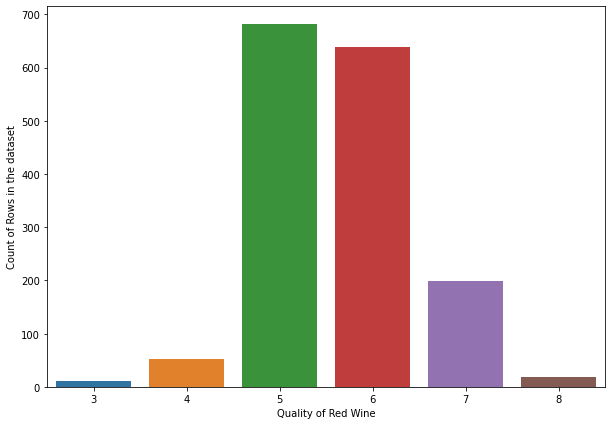

In [14]:
plt.figure(figsize=(10,7))
sns.countplot(x ='quality', data = df)
plt.xlabel('Quality of Red Wine')
plt.ylabel('Count of Rows in the dataset')
plt.show()

In the countplot representation we see the various categories of red wine quality and it shows that the number of data present for quality score 5 and 6 is way higher than it's counterparts. This indicates an imbalance which will need to be rectified so that our machine learning model do not get biased to a certain value during prediction.

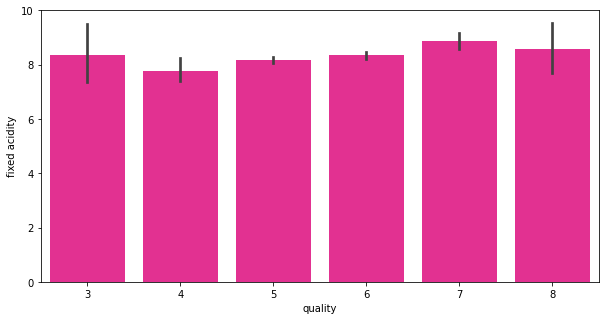

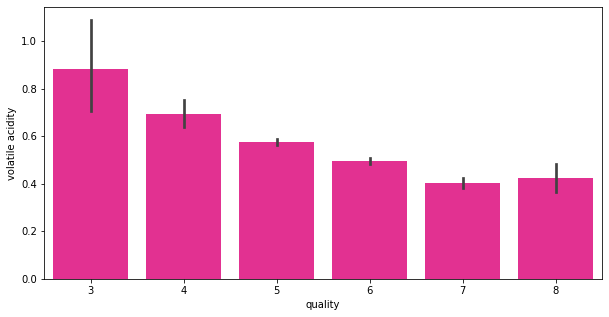

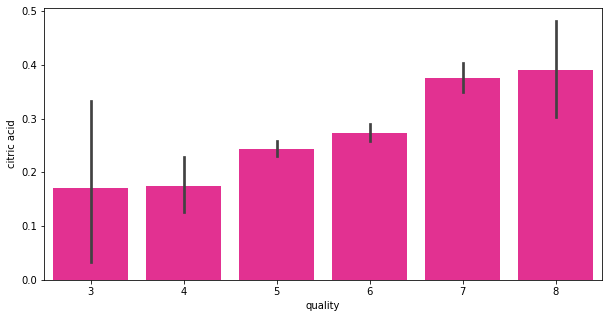

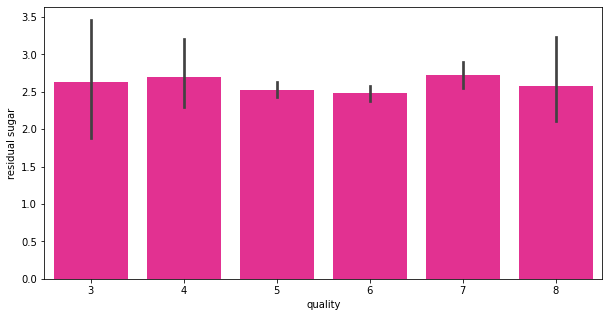

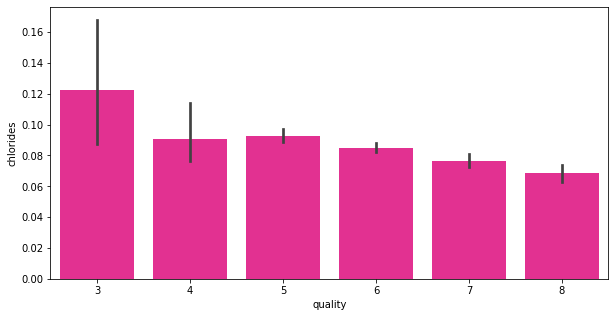

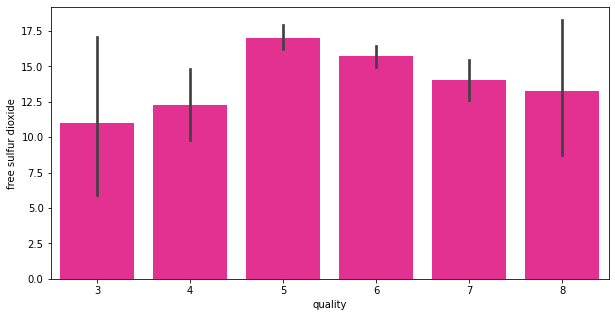

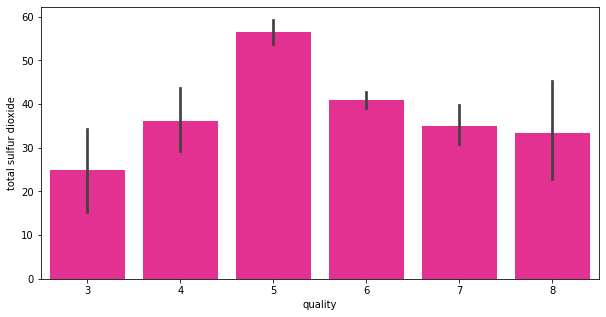

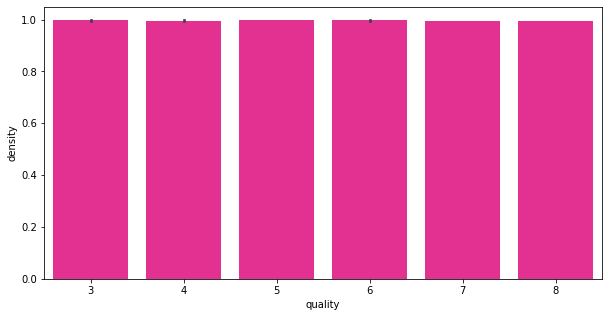

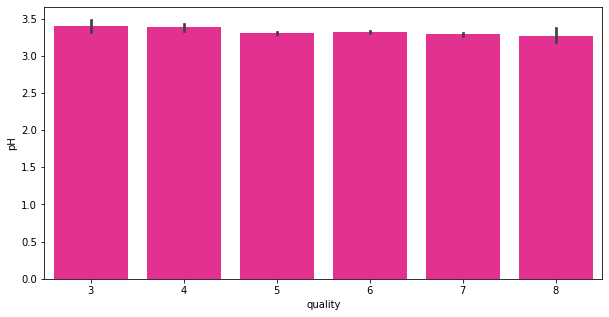

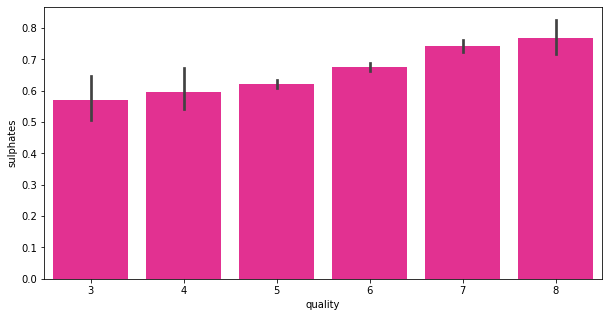

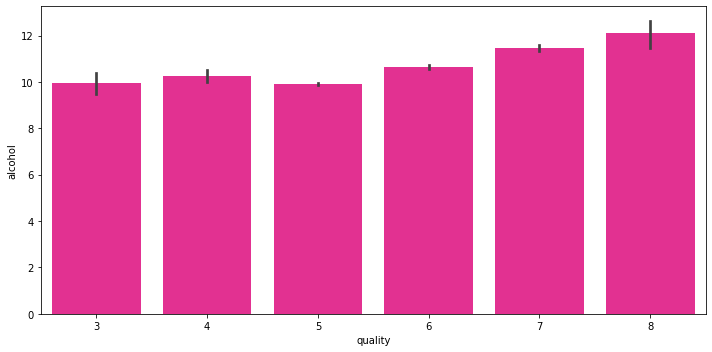

In [15]:
index=0
labels = df['quality']
features = df.drop('quality', axis=1)

for col in features.items():
    plt.figure(figsize=(10,5))
    sns.barplot(x=labels, y=col[index], data=df, color="deeppink")
plt.tight_layout()
plt.show()

With the feature vs label barplot we are able to see the trend corresponding to the impact each has with respect to predicting the quality column (our target variable).


Observations regarding feature compared to the label are:

1.fixed acidity vs quality - no fixed pattern.

2.volatile acidity vs quality - there is a decreasing trend.

3.citric acid vs quality - there is an increasing trend.

4.residual sugar vs quality - no fixed pattern

5.chlorides vs quality - there is a decreasing trend

6.free sulfur dioxide vs quality - no fixed pattern as it is increasing then decreasing

7.total sulfur dioxide vs quality - no fixed pattern as it is increasing then decreasing

8.density vs quality - no pattern at all

9.pH vs quality - no pattern at all

10.sulphates vs quality - there is an increasing trend

11.alcohol vs quality - there is an increasing trend


So here we can conclude that to get better quality wine citric acid, sulphates and alcohol columns play a major role.

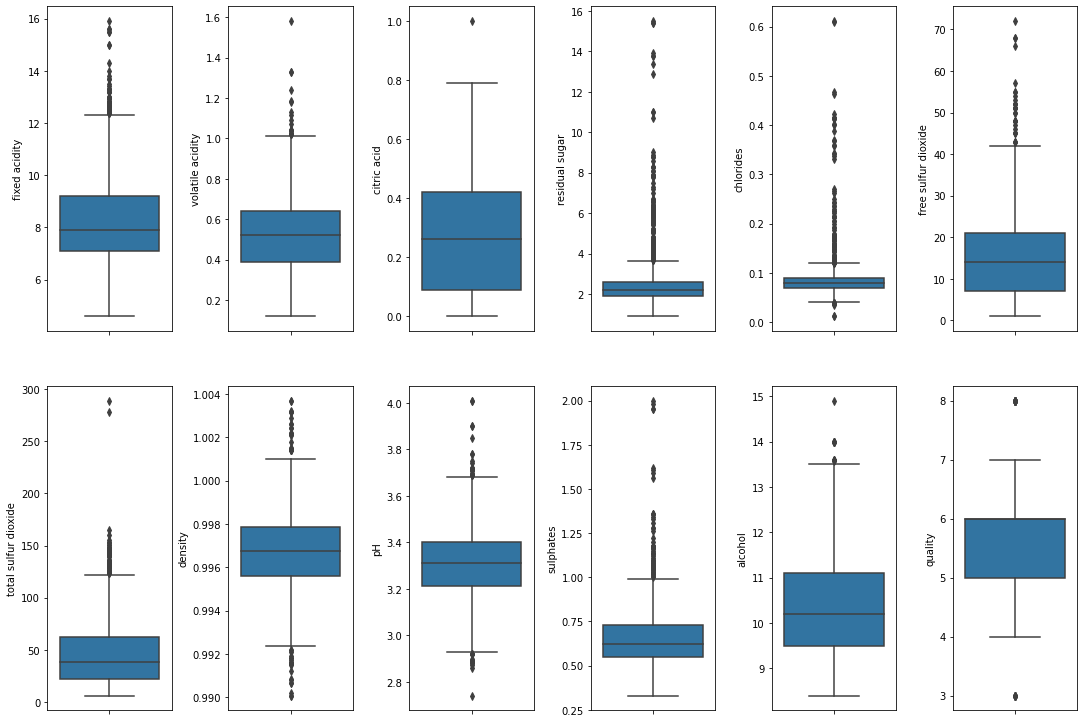

In [17]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(15,10))
index = 0
ax = ax.flatten()
for col, value in df.items():
    sns.boxplot(y=col, data=df, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

With the help of the above boxplot we are able to see the whisker details and outliers clearly. I am ignoring the continous outlier sections but the outliers that are single values and far away from the whiskers of the boxplot may need to be treated depending upon further analysis. Right now I am just trying to retain as much of data which is possible in the given dataset.

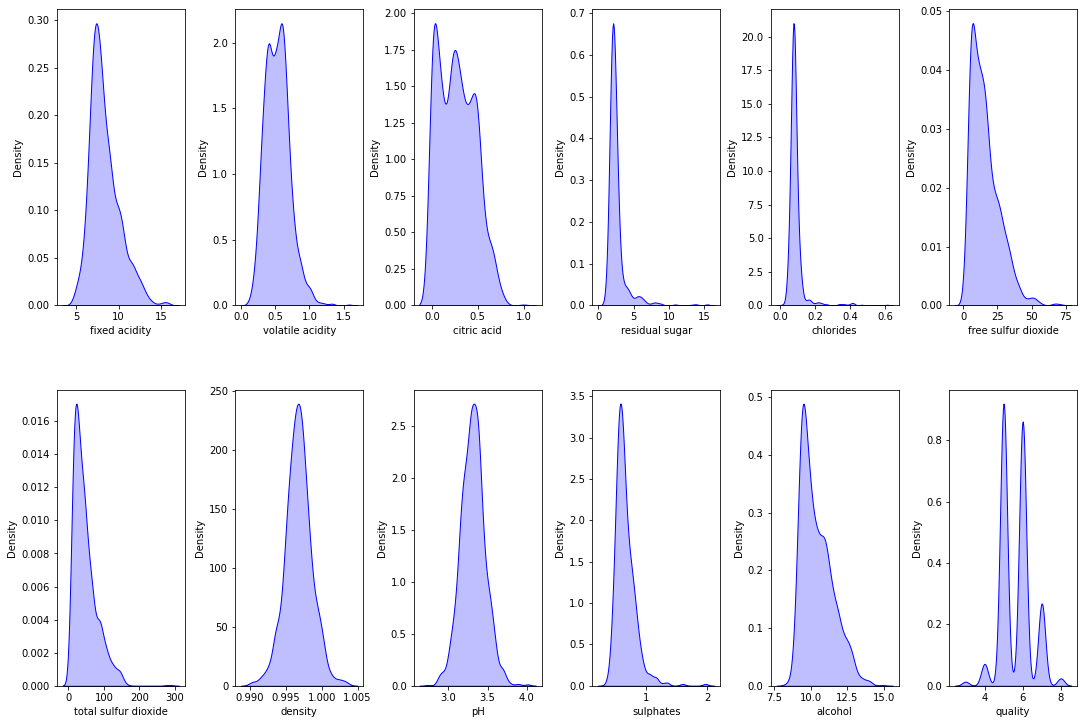

In [19]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(15,10))
index = 0
ax = ax.flatten()
for col, value in df.items():
    sns.distplot(value, ax=ax[index], hist=False, color="b", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

The distribution plots show that few of the columns are in normal distribution category showing a proper bell shape curve. However, we do see skewness in most of the feature columns like citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, sulphates and alcohol columns. We are going to ignore the label column since it is a categorical column and will need to fix the imbalance data inside it.

With respect to the treatment of skewness and outliers I will perform the removal or treatment after I can see the accuracy dependency of the machine learning models.

# Correlation using a Heatmap

1.Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the     same direction together.

2.Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the   other goes down.

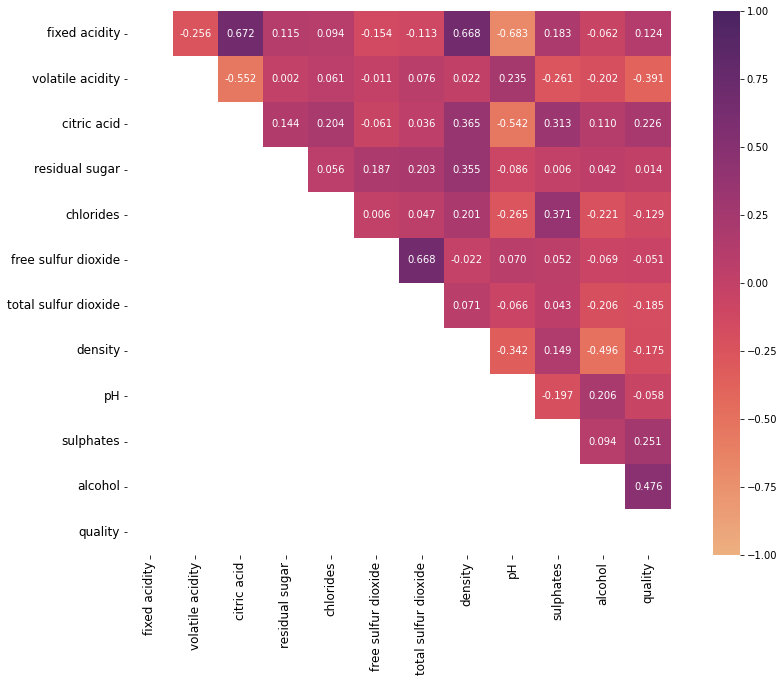

In [21]:
lower_triangle = np.tril(df.corr())
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':10}, cmap="flare", mask=lower_triangle)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

I see that the above heatmap shows the correlation matrix data wherein there are positive as well as negative correlations between the target label and other feture columns. A zero correlation indicates that there is no relationship between the variables. Looking at the above representation I see that quality column is positively correlated with alcohol and it is negatively correlated with the volatile acidity. The quality column is least correlated with residual sugar showing a coefficient value of 0.014 that close to 0. Similarly we can bifurcate all the other positively and negatively correlated feature columns with respect to the target label.

Also there are some highly positive and negative correlated feature columns that can pose the concern for multicollinearity. If the correlation coefficient, assuming it to be the variable 'r', is exactly +1 or -1, then it is called perfect multicollinearity. But even if this 'r' is close to -1 or +1 then one of the features should be removed from the model if at all possible.

Right now I see columns fixed acidity and citirc acid are positively correlated with a value of 0.672 which is close to 1. Similary, columns fixed acidity and density are positively correlated with a value of 0.668 again being close to 1. The other 2 column that's positively correlated are free sulfur dioxide and total sulfur dioxide with a value of 0.668 which is close to the value 1. The only negatively correlated columns that pop up are fixed acitidy and pH with a value -0.683 being close to the value -1.

We may need to deal with multicollinearity later if required to improve the accuracy of our machine learning models.

# Dropping column

In [22]:
df = df.drop('free sulfur dioxide', axis=1)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,44.0,0.99547,3.57,0.71,10.2,5


I feel that free sulfur dioxide and total sulfur dioxide are both indicating towards the same feature of sulfur dioxide therefore I am dropping the free option and keeping just the total option in our dataset.

# Outlier removal

In [23]:
df.shape

(1599, 11)

Confirming the number of columns and rows before removing the outliers from the dataset.

In [24]:
# Z score method

z=np.abs(zscore(df))
threshold=3
np.where(z>3)

df=df[(z<3).all(axis=1)]
df


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,44.0,0.99547,3.57,0.71,10.2,5


I have used the Z score method to get rid of outliers present in our dataset that are not in the acceptable range of +/-0.5 value of skewness.

In [25]:
# Percentage of Data Loss

data_loss=(1599-1464)/1599*100 
# 1599 (number of rows in the original dataframe) and 1464 (number of rows after outlier removal)
data_loss

8.442776735459661

# Splitting the dataset into 2 variables namely 'X' and 'Y' for feature and label

In [26]:
X = df.drop('quality', axis=1)
Y = df['quality']

I have split the dataset into features and labels where X represents all the feature columns and Y represents the target label column.

# Taking care of class imbalance

In [27]:
Y.value_counts()

5    624
6    590
7    187
4     47
8     16
Name: quality, dtype: int64

Listing the values of our label column to count the number of rows occupied by each category. This indicates class imbalance that we will need to fix by using the oversampling method.

In [28]:
# adding samples to make all the categorical quality values same

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

SMOTE is the over sampling mechanism that we are using to ensure that all the categories present in our target label have the same value.

In [29]:
Y.value_counts()

5    624
6    624
7    624
4    624
8    624
Name: quality, dtype: int64

After applying over sampling we are one again listing the values of our label column to cross verify the updated information. Here we see that we have successfully resolved the class imbalance problem and now all the categories have same data ensuring that the machine learning model does not get biased towards one category.

In [30]:
Y # Displaying just the label

0       5
1       5
2       5
3       6
4       5
       ..
3115    8
3116    8
3117    8
3118    8
3119    8
Name: quality, Length: 3120, dtype: int64

# Label Binarization

In [31]:
Y = Y.apply(lambda y_value:1 if y_value>=7 else 0) # 1 is for good quality and 0 for bad (not good) quality
Y # Displaying the label after applying label binarization

0       0
1       0
2       0
3       0
4       0
       ..
3115    1
3116    1
3117    1
3118    1
3119    1
Name: quality, Length: 3120, dtype: int64

Using the label binarization technique we have tagged the categories present in our target label to 2 major class that are 0 for bad quality wine and 1 for good quality wine.

In [32]:
X # Displaying all the features except the label

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.400000,0.700000,0.000000,1.900000,0.076000,34.000000,0.997800,3.510000,0.560000,9.400000
1,7.800000,0.880000,0.000000,2.600000,0.098000,67.000000,0.996800,3.200000,0.680000,9.800000
2,7.800000,0.760000,0.040000,2.300000,0.092000,54.000000,0.997000,3.260000,0.650000,9.800000
3,11.200000,0.280000,0.560000,1.900000,0.075000,60.000000,0.998000,3.160000,0.580000,9.800000
4,7.400000,0.700000,0.000000,1.900000,0.076000,34.000000,0.997800,3.510000,0.560000,9.400000
...,...,...,...,...,...,...,...,...,...,...
3115,11.017249,0.323470,0.632444,2.671458,0.074021,31.694043,0.998229,3.038275,0.833470,10.810266
3116,9.683176,0.344190,0.471896,2.338531,0.067385,15.128436,0.996851,3.173242,0.780735,10.709479
3117,9.633067,0.508871,0.511855,3.746777,0.080871,21.137093,0.996830,3.228548,0.694274,12.545163
3118,12.481529,0.311008,0.713446,2.235289,0.072151,29.201653,0.998665,2.891847,0.821008,9.875620


# Feature Scaling

In [33]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X # Displaying all the features after applying scaling technique to avoid bias output

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.667334,1.030986,-1.498141,-0.640417,-0.147005,-0.108819,0.830674,1.466500,-0.799733,-1.266923
1,-0.417607,2.041291,-1.498141,0.141091,1.064173,1.148981,0.221075,-0.737256,0.107783,-0.904997
2,-0.417607,1.367754,-1.293890,-0.193841,0.733851,0.653484,0.342995,-0.310723,-0.119096,-0.904997
3,1.705072,-1.326392,1.361375,-0.640417,-0.202059,0.882175,0.952593,-1.021612,-0.648481,-0.904997
4,-0.667334,1.030986,-1.498141,-0.640417,-0.147005,-0.108819,0.830674,1.466500,-0.799733,-1.266923
...,...,...,...,...,...,...,...,...,...,...
3115,1.590977,-1.082402,1.731292,0.220869,-0.255982,-0.196711,1.091913,-1.886941,1.268422,0.009108
3116,0.758092,-0.966108,0.911490,-0.150824,-0.621274,-0.828112,0.252393,-0.927478,0.869601,-0.082086
3117,0.726809,-0.041783,1.115533,1.421398,0.121159,-0.599091,0.239119,-0.534309,0.215733,1.578870
3118,2.505152,-1.152349,2.144914,-0.266087,-0.358893,-0.291709,1.357800,-2.927881,1.174176,-0.836575


Even though all our feature columns were of float data type I was unhappy with the decimal place differences and was worried that it might make my model biased. Therefore I am using the Standard Scaler method to ensure all my feature columns have been standardized.

# Creating the training and testing data sets

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

I am taking 20 percent of the complete dataset for training purpose and the remaing 80 percent with be used to train the machine learning models

# Machine Learning Model for Classification and Evaluation Metrics

In [35]:
# Classification Model Function

def classify(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # Accuracy Score
    acc_score = (accuracy_score(Y_test, pred))*100
    print("Accuracy Score:", acc_score)
    
    # Classification Report
    class_report = classification_report(Y_test, pred)
    print("\nClassification Report:\n", class_report)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of accuracy minus cv scores
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is", result)

I have defined a class that will perform the train-test split, training of machine learning model, predicting the label value, getting the accuracy score, generating the classification report, getting the cross validation score and the result of difference between the accuracy score and cross validation score for any machine learning model that calls for this function.

In [36]:
# Logistic Regression

model=LogisticRegression()
classify(model, X, Y)

Accuracy Score: 90.38461538461539

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       391
           1       0.85      0.90      0.87       233

    accuracy                           0.90       624
   macro avg       0.89      0.90      0.90       624
weighted avg       0.91      0.90      0.90       624

Cross Validation Score: 87.72435897435898

Accuracy Score - Cross Validation Score is 2.660256410256409


Created the Logistic Regression Model and checked for it's evaluation metrics.

In [37]:
# Support Vector Classifier

model=SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)
classify(model, X, Y)

Accuracy Score: 92.62820512820514

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       391
           1       0.88      0.93      0.90       233

    accuracy                           0.93       624
   macro avg       0.92      0.93      0.92       624
weighted avg       0.93      0.93      0.93       624

Cross Validation Score: 90.44871794871796

Accuracy Score - Cross Validation Score is 2.1794871794871824


Created the Support Vector Classifier Model and checked for it's evaluation metrics.

In [38]:
# Decision Tree Classifier

model=DecisionTreeClassifier(random_state=21, max_depth=15)
classify(model, X, Y)

Accuracy Score: 91.34615384615384

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       391
           1       0.86      0.91      0.89       233

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.91       624
weighted avg       0.92      0.91      0.91       624

Cross Validation Score: 88.01282051282051

Accuracy Score - Cross Validation Score is 3.3333333333333286


Created the Decision Tree Classifier Model and checked for it's evaluation metrics.

In [39]:
# Random Forest Classifier

model=RandomForestClassifier(max_depth=15, random_state=111)
classify(model, X, Y)

Accuracy Score: 95.83333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       391
           1       0.93      0.96      0.95       233

    accuracy                           0.96       624
   macro avg       0.95      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624

Cross Validation Score: 92.53205128205127

Accuracy Score - Cross Validation Score is 3.3012820512820724


In [40]:
# Random Forest Classifier

model=RandomForestClassifier(max_depth=15, random_state=111)
classify(model, X, Y)

Accuracy Score: 95.83333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       391
           1       0.93      0.96      0.95       233

    accuracy                           0.96       624
   macro avg       0.95      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624

Cross Validation Score: 92.53205128205127

Accuracy Score - Cross Validation Score is 3.3012820512820724


Created the Random Forest Classifier Model and checked for it's evaluation metrics.

In [41]:
# K Neighbors Classifier

model=KNeighborsClassifier(n_neighbors=15)
classify(model, X, Y)

Accuracy Score: 91.34615384615384

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       391
           1       0.84      0.94      0.89       233

    accuracy                           0.91       624
   macro avg       0.90      0.92      0.91       624
weighted avg       0.92      0.91      0.91       624

Cross Validation Score: 88.65384615384617

Accuracy Score - Cross Validation Score is 2.692307692307665


Created the K Neighbors Classifier Model and checked for it's evaluation metrics.

In [42]:
# Extra Trees Classifier

model=ExtraTreesClassifier()
classify(model, X, Y)

Accuracy Score: 95.99358974358975

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       391
           1       0.94      0.96      0.95       233

    accuracy                           0.96       624
   macro avg       0.96      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624

Cross Validation Score: 93.46153846153847

Accuracy Score - Cross Validation Score is 2.5320512820512846


Created the Extra Trees Classifier Model and checked for it's evaluation metrics.

In [43]:
# XGB Classifier

model=xgb.XGBClassifier(verbosity=0)
classify(model, X, Y)

Accuracy Score: 96.31410256410257

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       391
           1       0.93      0.97      0.95       233

    accuracy                           0.96       624
   macro avg       0.96      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624

Cross Validation Score: 92.01923076923076

Accuracy Score - Cross Validation Score is 4.29487179487181


Created the XGB Classifier Model and checked for it's evaluation metrics.

In [44]:
# LGBM Classifier

model=lgb.LGBMClassifier()
classify(model, X, Y)

Accuracy Score: 96.15384615384616

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       391
           1       0.93      0.97      0.95       233

    accuracy                           0.96       624
   macro avg       0.96      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624

Cross Validation Score: 92.27564102564102

Accuracy Score - Cross Validation Score is 3.8782051282051384


Created the LGBM Classifier Model and checked for it's evaluation metrics.

# Hyper parameter tuning on the best ML Model

In [45]:
# Choosing Support Vector Classifier

svc_param = {'kernel' : ['poly', 'sigmoid', 'rbf'],
             'gamma' : ['scale', 'auto'],
             'shrinking' : [True, False],
             'random_state' : [21,42,104],
             'probability' : [True, False],
             'decision_function_shape' : ['ovo', 'ovr'],
             'verbose' : [True, False]}

After comparing all the classification models I have selected Support Vector Classifier as my best model and have listed down it's parameters above referring the sklearn webpage.

In [46]:
GSCV = GridSearchCV(SVC(), svc_param, cv=5)

I am using the Grid Search CV method for hyper parameter tuning my best model.

In [47]:
GSCV.fit(X_train,Y_train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'sigmoid', 'rbf'],
                         'probability': [True, False],
                         'random_state': [21, 42, 104],
                         'shrinking': [True, False], 'verbose': [True, False]})

I have trained the Grid Search CV with the list of parameters I feel it should check for best possible outcomes.

In [48]:
GSCV.best_params_

{'decision_function_shape': 'ovo',
 'gamma': 'auto',
 'kernel': 'rbf',
 'probability': True,
 'random_state': 21,
 'shrinking': True,
 'verbose': True}

Here the Grid Search CV has provided me with the best parameters list out of all the combinations it used to train the model.

In [49]:
Final_Model = SVC(decision_function_shape='ovo', gamma='scale', kernel='rbf', probability=True, random_state=21,
                 shrinking=True, verbose=True)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_acc = (accuracy_score(Y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)

[LibSVM]Accuracy score for the Best Model is: 92.62820512820514


I have successfully incorporated the Hyper Parameter Tuning on my Final Model and received the accuracy score for it.

# AUC ROC Curve

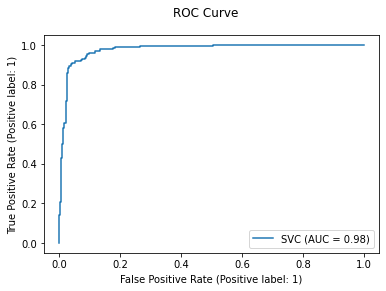

In [50]:
disp = metrics.plot_roc_curve(Final_Model, X_test, Y_test)
disp.figure_.suptitle("ROC Curve")
plt.show()

I have generated the ROC Curve for my final model and it shows the AUC score for my final model to be of 98%

# Confusion Matrix

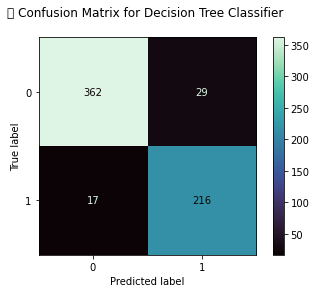

In [51]:
class_names = df.columns
metrics.plot_confusion_matrix(Classifier, X_test, Y_test, cmap='mako')
plt.title('\t Confusion Matrix for Decision Tree Classifier \n')
plt.show()

With the help of above confusion matrix I am able to understand the number of times I got the correct outputs and the number of times my model missed to provide the correct prediction (depicting in the black boxes)

# Saving the model

In [52]:
filename = "FinalModel_3.pkl"
joblib.dump(Final_Model, filename)

['FinalModel_3.pkl']